# Renewable Energy Forecasting – Example Notebook

This notebook walks through the core steps of the renewable energy forecasting project:

1. Explore the raw hourly solar dataset (`solar_energy.csv`), including time coverage, seasonality,
   weather relationships, and the distribution of `energy_mwh`.
2. Preview engineered features created by the project utilities.
3. Load the processed dataset (`train.csv`), train a baseline Random Forest model, and evaluate it
   on a time-aware validation split.
4. Visualize predictions vs actual values and inspect feature importances.


In [1]:
import sys
from pathlib import Path


PROJECT_ROOT = Path.cwd().resolve().parent
sys.path.append(str(PROJECT_ROOT))

from RenewableEnergy_utils import (
    load_data,
    make_basic_time_features,
    train_val_split,
    TIME_COL,
    TARGET_COL
)

print("Utils imported successfully!")


Utils imported successfully!


In [2]:
from pathlib import Path
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Notebook lives in .../UmdTask15_.../examples
PROJECT_ROOT = Path.cwd().resolve().parent
DATA_DIR = PROJECT_ROOT / "data"
RAW_PATH = DATA_DIR / "raw" / "solar_energy.csv"


sys.path.append(str(PROJECT_ROOT))

from RenewableEnergy_utils import (
    load_data,
    make_basic_time_features,
    train_val_split,
    TIME_COL,
    TARGET_COL,
)

PROJECT_ROOT, RAW_PATH


(PosixPath('/work/class_project/MSML610/Fall2025/Projects/UmdTask15_Fall2025_Renewable_Energy_Production'),
 PosixPath('/work/class_project/MSML610/Fall2025/Projects/UmdTask15_Fall2025_Renewable_Energy_Production/data/raw/solar_energy.csv'))

In [3]:
df_raw = load_data(str(RAW_PATH))
print("Raw shape:", df_raw.shape)
df_raw.head()


Raw shape: (4320, 5)


,energy_mwh,temp_c,cloud_cover,solar_radiation,wind_speed
timestamp,,,,,
2024-01-01 00:00:00,0.319,-2.66,0.338,0.0,3.32
2024-01-01 01:00:00,0.491,-2.26,0.410,0.0,3.89
2024-01-01 02:00:00,0.593,1.40,0.526,0.0,4.42
2024-01-01 03:00:00,0.048,-1.41,0.414,0.0,3.94
2024-01-01 04:00:00,0.000,1.97,0.564,0.0,2.96


In [4]:
## 1. Quick look at the raw data


In [5]:
print("Index name:", df_raw.index.name)
print("\nColumns:", df_raw.columns.tolist())

print("\nData types:")
print(df_raw.dtypes)

print("\nMissing values per column:")
print(df_raw.isna().sum())


Index name: timestamp

Columns: ['energy_mwh', 'temp_c', 'cloud_cover', 'solar_radiation', 'wind_speed']

Data types:
energy_mwh         float64
temp_c             float64
cloud_cover        float64
solar_radiation    float64
wind_speed         float64
dtype: object

Missing values per column:
energy_mwh         0
temp_c             0
cloud_cover        0
solar_radiation    0
wind_speed         0
dtype: int64


In [6]:
## 2. Time coverage and granularity


In [7]:
print("Start timestamp:", df_raw.index.min())
print("End timestamp:", df_raw.index.max())
print("Number of rows:", len(df_raw))

time_diffs = df_raw.index.to_series().diff().dropna()
print("\nMost common time difference:", time_diffs.mode()[0])
print("Unique time differences (first 5):", time_diffs.unique()[:5])


Start timestamp: 2024-01-01 00:00:00
End timestamp: 2024-06-28 23:00:00
Number of rows: 4320

Most common time difference: 0 days 01:00:00
Unique time differences (first 5): <TimedeltaArray>
['0 days 01:00:00']
Length: 1, dtype: timedelta64[ns]


In [8]:
## 3. Target behaviour over time


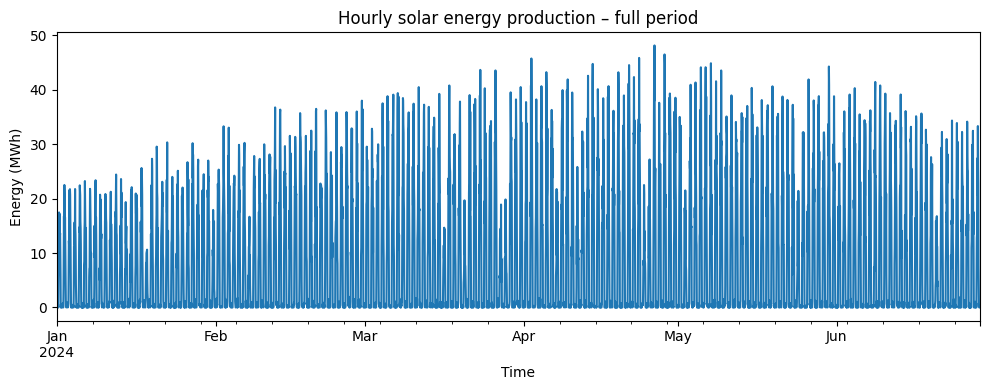

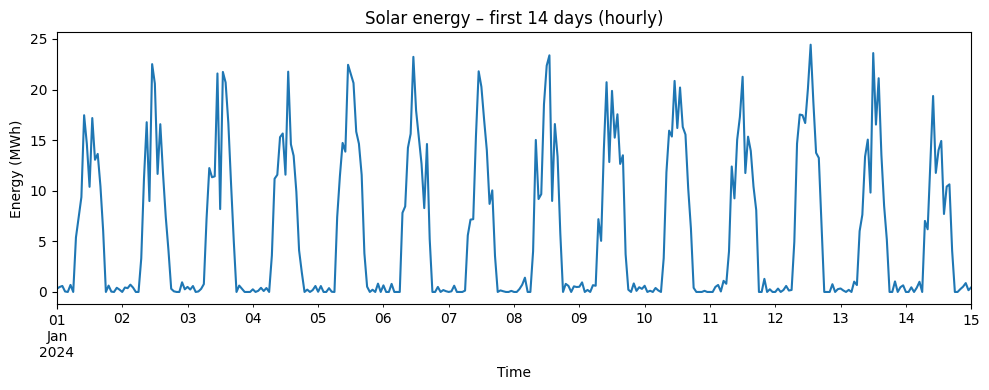

In [9]:
plt.figure(figsize=(10, 4))
df_raw[TARGET_COL].plot()
plt.xlabel("Time")
plt.ylabel("Energy (MWh)")
plt.title("Hourly solar energy production – full period")
plt.tight_layout()
plt.show()

# Zoom into first 14 days for daily pattern
start = df_raw.index.min()
end = start + pd.Timedelta(days=14)
df_slice = df_raw.loc[start:end]

plt.figure(figsize=(10, 4))
df_slice[TARGET_COL].plot()
plt.xlabel("Time")
plt.ylabel("Energy (MWh)")
plt.title("Solar energy – first 14 days (hourly)")
plt.tight_layout()
plt.show()


In [22]:
## 4. Daily and weekly seasonality


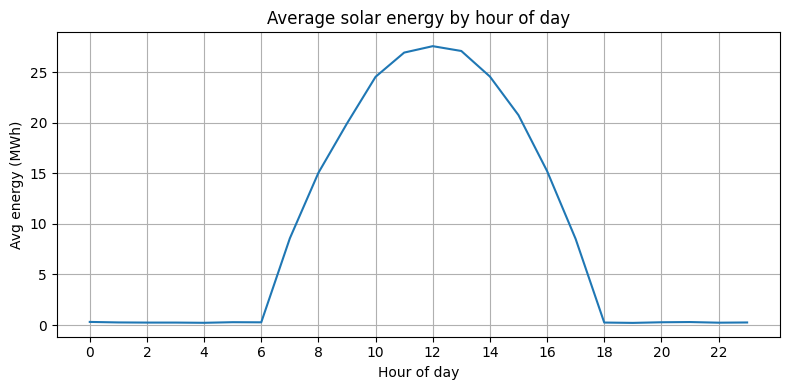

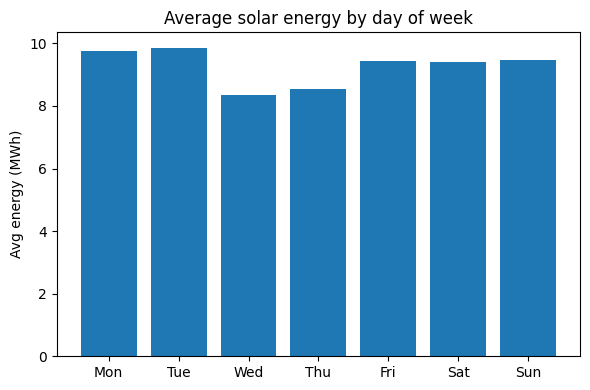

In [10]:
# Daily pattern
df_tmp = df_raw.copy()
df_tmp["hour"] = df_tmp.index.hour
avg_hour = df_tmp.groupby("hour")[TARGET_COL].mean()

plt.figure(figsize=(8, 4))
plt.plot(avg_hour.index, avg_hour.values)
plt.xticks(range(0, 24, 2))
plt.xlabel("Hour of day")
plt.ylabel("Avg energy (MWh)")
plt.title("Average solar energy by hour of day")
plt.grid(True)
plt.tight_layout()
plt.show()

# Weekly pattern
df_tmp["dayofweek"] = df_tmp.index.dayofweek
avg_dow = df_tmp.groupby("dayofweek")[TARGET_COL].mean()

plt.figure(figsize=(6, 4))
plt.bar(avg_dow.index, avg_dow.values)
plt.xticks(range(7), ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"])
plt.ylabel("Avg energy (MWh)")
plt.title("Average solar energy by day of week")
plt.tight_layout()
plt.show()


In [24]:
## 5. Relationship between energy and weather variables


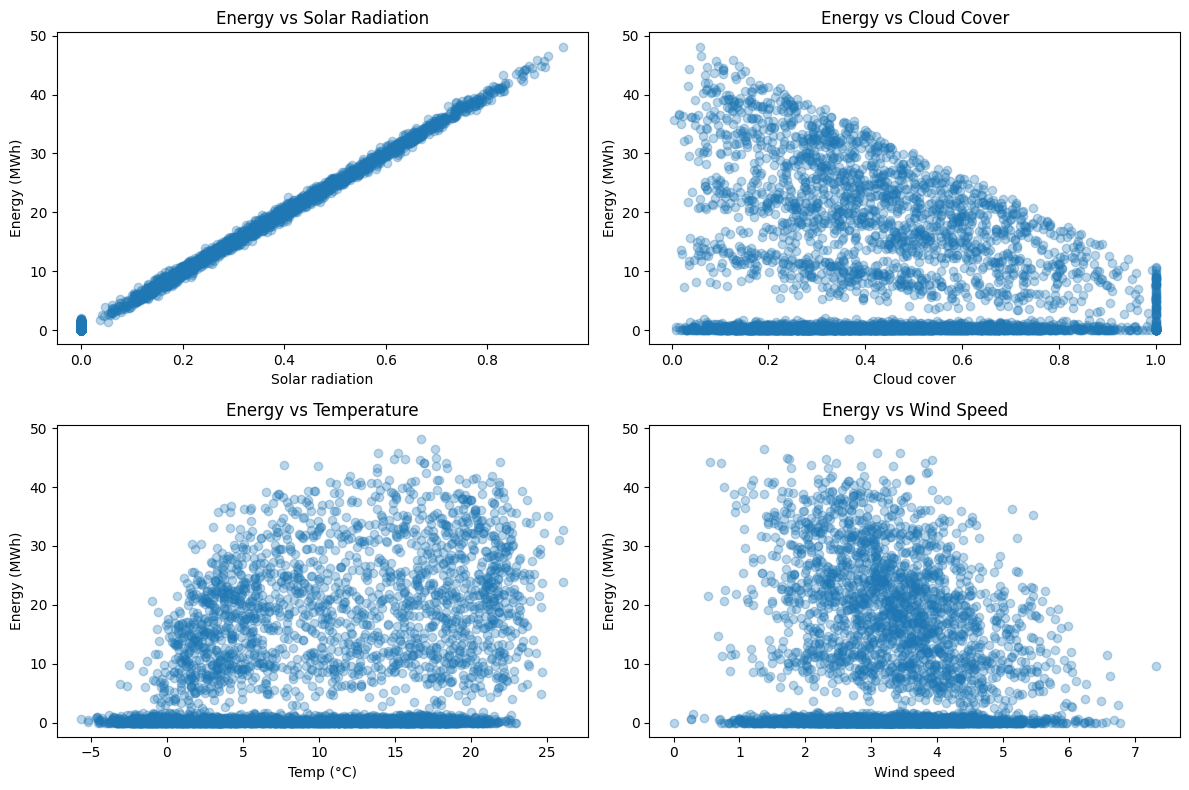

In [11]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

axes[0, 0].scatter(df_raw["solar_radiation"], df_raw[TARGET_COL], alpha=0.3)
axes[0, 0].set_title("Energy vs Solar Radiation")
axes[0, 0].set_xlabel("Solar radiation")
axes[0, 0].set_ylabel("Energy (MWh)")

axes[0, 1].scatter(df_raw["cloud_cover"], df_raw[TARGET_COL], alpha=0.3)
axes[0, 1].set_title("Energy vs Cloud Cover")
axes[0, 1].set_xlabel("Cloud cover")
axes[0, 1].set_ylabel("Energy (MWh)")

axes[1, 0].scatter(df_raw["temp_c"], df_raw[TARGET_COL], alpha=0.3)
axes[1, 0].set_title("Energy vs Temperature")
axes[1, 0].set_xlabel("Temp (°C)")
axes[1, 0].set_ylabel("Energy (MWh)")

axes[1, 1].scatter(df_raw["wind_speed"], df_raw[TARGET_COL], alpha=0.3)
axes[1, 1].set_title("Energy vs Wind Speed")
axes[1, 1].set_xlabel("Wind speed")
axes[1, 1].set_ylabel("Energy (MWh)")

plt.tight_layout()
plt.show()


In [26]:
## 6. Correlation and distribution of the target


                 energy_mwh    temp_c  cloud_cover  solar_radiation  \
energy_mwh         1.000000  0.287799    -0.206079         0.999104   
temp_c             0.287799  1.000000    -0.014800         0.288433   
cloud_cover       -0.206079 -0.014800     1.000000        -0.204334   
solar_radiation    0.999104  0.288433    -0.204334         1.000000   
wind_speed        -0.134415 -0.003032     0.651426        -0.132693   

                 wind_speed  
energy_mwh        -0.134415  
temp_c            -0.003032  
cloud_cover        0.651426  
solar_radiation   -0.132693  
wind_speed         1.000000  


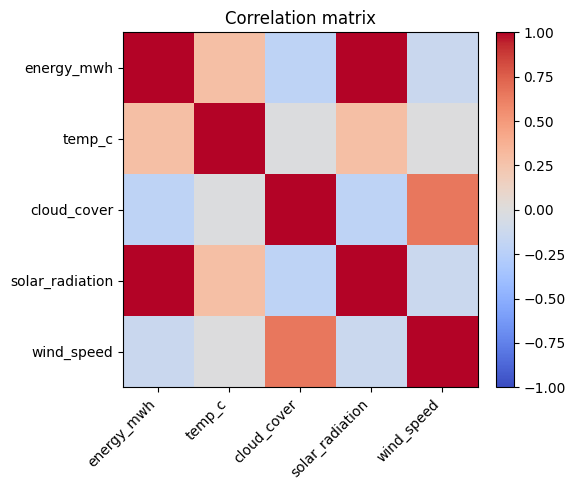

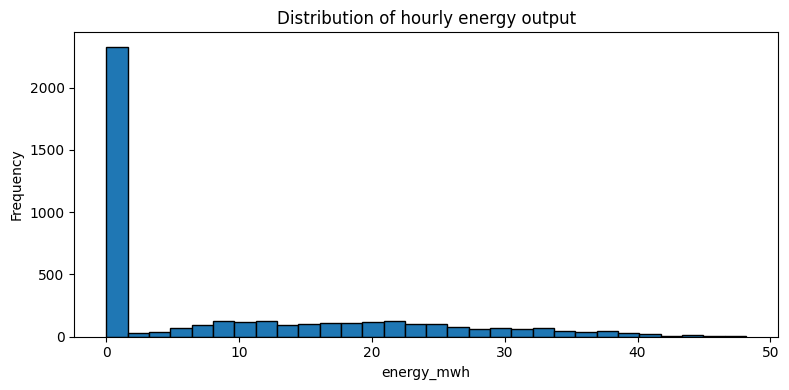

In [12]:
cols = [TARGET_COL, "temp_c", "cloud_cover", "solar_radiation", "wind_speed"]
corr = df_raw[cols].corr()

print(corr)

plt.figure(figsize=(6, 5))
im = plt.imshow(corr, cmap="coolwarm", vmin=-1, vmax=1)
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.xticks(range(len(cols)), cols, rotation=45, ha="right")
plt.yticks(range(len(cols)), cols)
plt.title("Correlation matrix")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 4))
plt.hist(df_raw[TARGET_COL], bins=30, edgecolor="black")
plt.xlabel("energy_mwh")
plt.ylabel("Frequency")
plt.title("Distribution of hourly energy output")
plt.tight_layout()
plt.show()


In [28]:
## 7. Feature engineering with make_basic_time_features


In [13]:
df_feats = make_basic_time_features(df_raw)

print("Features shape:", df_feats.shape)
df_feats.head()


Features shape: (4296, 13)


,energy_mwh,temp_c,cloud_cover,solar_radiation,wind_speed,hour,dayofweek,month,energy_mwh_lag_1,energy_mwh_lag_2,energy_mwh_lag_24,energy_mwh_rollmean_3,energy_mwh_rollmean_24
timestamp,,,,,,,,,,,,,
2024-01-02 00:00:00,0.000,-2.72,0.516,0.0,3.61,0,1,1,0.230,0.413,0.319,0.214333,5.352333
2024-01-02 01:00:00,0.438,-1.63,0.469,0.0,2.62,1,1,1,0.000,0.230,0.491,0.214333,5.339042
2024-01-02 02:00:00,0.377,-0.89,0.143,0.0,2.39,2,1,1,0.438,0.000,0.593,0.222667,5.336833
2024-01-02 03:00:00,0.721,-0.35,0.559,0.0,3.10,3,1,1,0.377,0.438,0.048,0.271667,5.327833
2024-01-02 04:00:00,0.426,0.68,0.365,0.0,3.62,4,1,1,0.721,0.377,0.000,0.512000,5.355875


In [30]:
## 8. Time-based train / validation split


In [14]:
X_train, X_val, y_train, y_val, feature_cols = train_val_split(df_feats, test_size_days=7)

print("X_train:", X_train.shape)
print("X_val  :", X_val.shape)
print("y_train:", y_train.shape)
print("y_val  :", y_val.shape)


X_train: (4128, 12)
X_val  : (168, 12)
y_train: (4128,)
y_val  : (168,)


In [32]:
## 9. Baseline Random Forest model


In [15]:
rf = RandomForestRegressor(
    n_estimators=200,
    random_state=42,
    n_jobs=-1,
)

rf.fit(X_train, y_train)

y_pred = rf.predict(X_val)

mae = mean_absolute_error(y_val, y_pred)
rmse = mean_squared_error(y_val, y_pred, squared=False)

print(f"Validation MAE : {mae:.4f}")
print(f"Validation RMSE: {rmse:.4f}")


Validation MAE : 0.3972
Validation RMSE: 0.5188


In [16]:
df_feats = make_basic_time_features(df_raw)
X_train, X_val, y_train, y_val, feature_cols = train_val_split(df_feats, test_size_days=7)


In [34]:
## 10. Predictions vs actual values on validation period


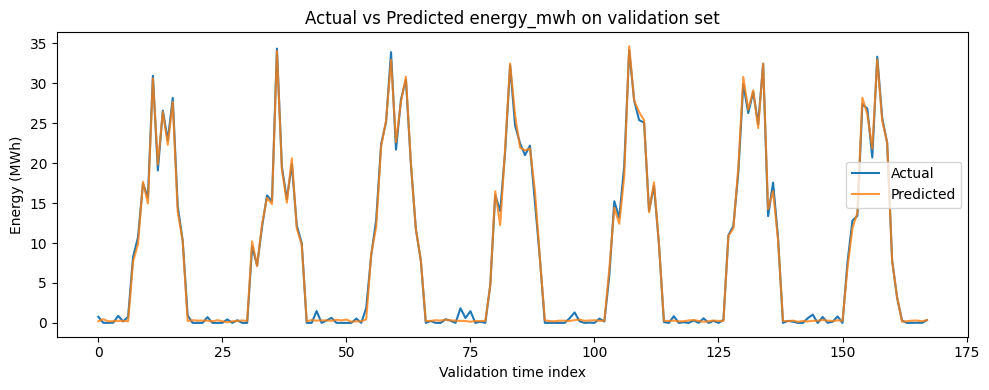

In [17]:
plt.figure(figsize=(10, 4))
plt.plot(y_val.values, label="Actual")
plt.plot(y_pred, label="Predicted", alpha=0.8)
plt.xlabel("Validation time index")
plt.ylabel("Energy (MWh)")
plt.title("Actual vs Predicted energy_mwh on validation set")
plt.legend()
plt.tight_layout()
plt.show()


In [36]:
## 11. Feature importance


In [18]:
importances = rf.feature_importances_
fi = pd.Series(importances, index=feature_cols).sort_values(ascending=False)

fi.head(15)


solar_radiation           0.998293
energy_mwh_lag_24         0.000345
energy_mwh_rollmean_24    0.000196
wind_speed                0.000193
temp_c                    0.000183
cloud_cover               0.000175
energy_mwh_rollmean_3     0.000141
energy_mwh_lag_2          0.000135
energy_mwh_lag_1          0.000132
dayofweek                 0.000103
hour                      0.000064
month                     0.000039
dtype: float64

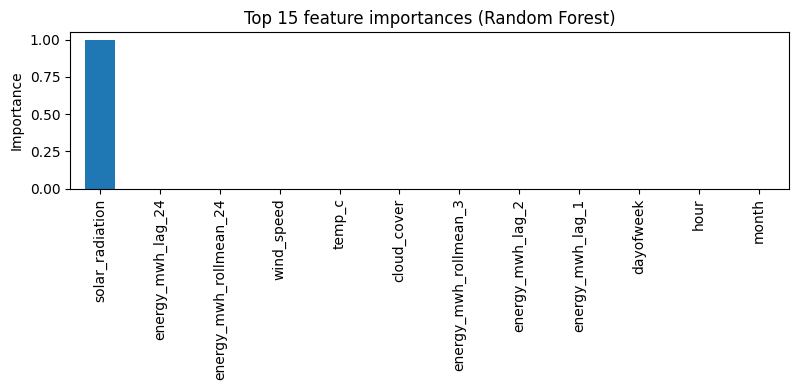

In [19]:
plt.figure(figsize=(8, 4))
fi.head(15).plot(kind="bar")
plt.ylabel("Importance")
plt.title("Top 15 feature importances (Random Forest)")
plt.tight_layout()
plt.show()


## 12. Summary

In this notebook I:

- Loaded the raw hourly solar dataset and confirmed its structure and coverage.
- Explored daily and weekly seasonality and how energy depends on weather variables.
- Built time-based features (calendar, lags, rolling means) using `make_basic_time_features`.
- Created a time-aware train/validation split with `train_val_split`.
- Trained a baseline Random Forest model and evaluated it using MAE and RMSE.
- Compared predictions against the actual validation values and inspected feature importances.

This gives a clear baseline that matches the project utilities and the training
pipeline used in `scripts/train.py`. More complex models and MLflow experiments
can be added on top of this baseline.
